# An Example Run of the Double Genetic Algorithm
This jupyter notebook and the accompanying module, GA_funcs, define and perform an example run of the 'double genetic algorithm' I created to automate trading strategy development.

The double genetic algorithm works by running a low level genetic algorithm called 'humanity,' which optimises the parameters of trading rules *given a set of measures*. For example, let's say you want to create a rule based on the difference of two moving averages of price for each stock. Given that you are using this measure, what time frame should the averages take and what threshold must this difference cross in order to trigger a buy and sell order? The lower level genetic algorithm decides this. The higher level genetic algorithm called 'divinity' uses the pseudo-out-of-sample performance of the lower level genetic algorithm as a fitness function for deciding which set of measures should be used - should a moving average be used or should a rolling measure of standard deviation be used? or perhaps both? This is what 'divinity' determines.

This notebook is divided into three parts:
1. I define the genetic algorithm functions and some supporting functions. However, most of the functions that allow these genetic algorithms to work are defined in the GA_funcs file, including functions that 1) generate a starter population 2) breed and mutate the best solutions from each populatione, and 3) simulate a trading portfolio to evaluate the performance of a potential solution. Note also that the importing of some functions into this main programme is required by best practice with the 'multiprocessing' module, so copying functions from GA_funcs into this notebook could cause errors (and vice versa).

2. I import data and perform some necessary setup outside of the algorithm in order to help it run faster.

3. I run the genetic algorithms. 

A final couple of notes are that 1) there is randomness incorporated into the algorithm to break indifference over stock choice, so your run will be different from mine, and 2) I define some solutions to be invalid (for example if the signals need so much data that trading only starts towards the end of the available period) and allow the population to degenerate if too many solutions are invalid. Smaller populations are more prone to this degeneration, which returns None objects, but populations around the size of those used in this notebook are fine.

In [11]:
from statistics import mean as avge
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from math import isnan
import warnings
import re
import pickle
from multiprocessing import Pool
from functools import partial
import random
from jupyterthemes import jtplot
from sklearn.preprocessing import StandardScaler
from itertools import combinations
# Just be aware that I use a dark theme, so you might want to remove this style setting if you do not.
jtplot.style('chesterish')
%matplotlib inline
from GA_funcs import *

# Part 1: Defining the genetic algorithm functions

In [12]:
def genesis(fitness,sex_func,buy_seed,sell_seed,pop_size,child_proportion,aristocracy,override_pop,
           override_scores,override_gen_fitness,override_king):
    '''
    genesis initiates the genetic algorithm by performing these steps: 1) using the starter_population
    function to create an initial population; 2) scoring this initial population; 3) sorting this
    population according to scores and recording the generational fitness as an average of aristocracy
    top fitness values, as well as recording the king; 4) breeding a proportion of the population and
    filling the rest of the population with the top survivors from the previous generation. 5) repeating
    steps 2 and 3 for the new population. I return a tuple of the population, their scores, the king from
    the previous population, a list of generational fitness, and a ranked_index which is a list 
    containing the rank of each member of the population for the corresponding iloc.
    '''
    # I check to see if there is a predefined population with which the user wishes to start
    if override_pop is None:
        # Otherwise I initialise by calling the starter_population function
        pop = starter_population(buy_seed,sell_seed,pop_size)
    else:
        pop = override_pop
    
    if override_scores is None:
        # I use multiprocessing to quickly generate the scores for the population using the given fitness
        # function.
        if __name__ == '__main__':
            p = Pool()
            scores = p.map(fitness,pop)
            p.close()
    else:
        scores = override_scores
    
    # I create filtr, which identifies those ilocs that are not nan...
    filtr = [num for num in range(len(scores)) if not isnan(scores[num])]
    # ...using filtr, I remove nans from scores and pop
    scores = [scores[num] for num in filtr]
    pop = [pop[num] for num in filtr]
    # finally, I create the ranked_index list, which gives the iloc of the pop member at increasing rank.
    # To wit, the last number in this list is the iloc of the highest ranking solution in the pop list.
    ranked_index = [x for _,x in sorted(zip(scores,range(len(scores))))]
    
    if override_gen_fitness is None:
        # Using aristocracy to determine the number of solutions to use to judge generational fitness, I
        # take an average and create the gen fitness list to store that average.
        fit_judge = -min(pop_size,aristocracy)
        gen_fitness = [avge([scores[i] for i in ranked_index[fit_judge:]])]
    else:
        gen_fitness = override_gen_fitness
    
    if override_king is None:
        # I also record the highest ranking solution and save it as the king, paired with its score.
        king = (pop[ranked_index[-1]],scores[ranked_index[-1]])
    else:
        king = override_king
    
    # I use the selection function to return a list of pairs of the ranks of selected breeding couples.
    choices = selection(len(pop),pop_size,child_proportion)
    # If the population degenerates too substantially for there to be enough unique couples to restore
    # the population to pop_size, the selection function will return None, and so genesis will return
    # A tuple of nones also.
    if choices is None:
        return (None,None,None,None,None)

    # I use the dating_app function to transform the choices variable into a list of couples of solutions
    parents = dating_app(pop, ranked_index, choices)

    # I use the given sex function to create a generation of children and unpack the list of tuples of 
    # children from each parent couple into a flat list.
    children = [sex_func(parent) for parent in parents]
    children = [genome for tup in children for genome in tup]
    
    # the resultant number of children determines how many of the previous generation will continue
    # on to the next generation. I fill up the next generation with the best members of the previous
    # generation until I reach pop size again, if there is any space that is.
    survivors = pop_size - len(children)
    if survivors == 0:
        pop = children
    else:
        pop = children + [pop[i] for i in ranked_index[-(pop_size - len(children)):]]
    
    # I obtain the scores from this new population...
    if __name__ == '__main__':
        p = Pool()
        scores = p.map(fitness,pop)
        p.close()
    
    # ...and filter and rank them in conjunction with the corresponding population.
    filtr = [num for num in range(len(scores)) if not isnan(scores[num])]
    scores = [scores[num] for num in filtr]
    pop = [pop[num] for num in filtr]
    ranked_index = [x for _,x in sorted(zip(scores,range(len(scores))))]
    
    # using aristocracy again, I judge the fitness of this generation and append the value to gen_fitness
    fit_judge = -min(pop_size,aristocracy)
    gen_fitness.append(avge([scores[i] for i in ranked_index[fit_judge:]]))        
    # I return the population, its scores, the king, gen_fitness, and ranked_index.
    return pop, scores, king, gen_fitness, ranked_index

def common_era(fitness,sex_func,pop,scores,ranked_index,gen_fitness,king,pop_size,child_proportion,
               aristocracy,apocalypse,stop_gap):
    '''
    common_era runs the genetic algorithm after it has been initiated by genesis. It does this by
    initiating a while loop that follows these steps: 1) updating the king; 2) selecting the parents that
    will breed the next generation; 3) breeding the parents with the given sex_func to produce a 
    proportion of the new population, and filling the rest of the new population with the king and
    the best from the previous generation; 4) scoring the new population; 5) filtering the new population
    and recording the generational fitness; 6) updating the value controlling the while loop. I return a 
    tuple of the population, their scores, the king from the last population, a ranked_index which is a 
    list containing the rank of each member of the population for the corresponding iloc, and a list of 
    generational fitness.
    '''
    # since genesis leaves off on the second generation, I set gen equal to two. and initiate a while
    # loop using gen and apocalypse.
    gen = 2
    while gen < apocalypse:
        # I check the scores of the previous generation and replace the king if the highest score
        # exceeds the current king.
        if scores[ranked_index[-1]] > king[1]:
            king = (pop[ranked_index[-1]],scores[ranked_index[-1]])
        # I use the selection function to return a list of pairs of the ranks of selected breeding 
        # couples.
        choices = selection(len(pop),pop_size,child_proportion)
        # If the population degenerates too substantially for there to be enough unique couples to restore
        # the population to pop_size, the selection function will return None, and so common_era will 
        # return a tuple of nones also.
        if choices is None:
            return (pop, scores, king, ranked_index, gen_fitness)
        # I use the dating_app function to transform the choices variable into a list of couples of 
        # solutions
        parents = dating_app(pop, ranked_index, choices)
        # I use the given sex function to create a generation of children and unpack the list of tuples of 
        # children from each parent couple into a flat list.
        children = [sex_func(parent) for parent in parents]
        children = [genome for tup in children for genome in tup]
        # the resultant number of children determines how many of the previous generation will continue
        # on to the next generation. I fill up the next generation with the best members of the previous
        # generation until I reach pop size again, if there is any space that is.
        survivors = pop_size - len(children)
        if survivors == 0:
            pop = children
        elif survivors == 1:
            pop = children + [pop[ranked_index[-1]]]
        else:
            pop = children + [pop[i] for i in ranked_index[1-(pop_size - len(children)):]] + [king[0]]        
        # I obtain the scores from this new population...
        if __name__ == '__main__':
            p = Pool()
            scores = p.map(fitness,pop)
            p.close()
        # ...and filter and rank them in conjunction with the corresponding population.
        filtr = [num for num in range(len(scores)) if not isnan(scores[num])]
        scores = [scores[num] for num in filtr]
        pop = [pop[num] for num in filtr]
        ranked_index = [x for _,x in sorted(zip(scores,range(len(scores))))]
        # using aristocracy again, I judge the fitness of this generation and append the value to 
        # gen_fitness
        fit_judge = -min(pop_size,aristocracy)
        gen_fitness.append(avge([scores[i] for i in ranked_index[fit_judge:]]))
        # Finally, I check how many generations ago the maximum generational fitness was. If it is more
        # than stop_gap generations ago, I terminate the loop by setting gen equal to apocalypse.
        # Otherwise I increase gen by one.
        if len(gen_fitness) - gen_fitness.index(max(gen_fitness)) - 1 >= stop_gap:
            gen = apocalypse
        else:
            gen += 1
    # I then return everything I need to either analyse the results of humanity or commence armageddon.
    return pop, scores, gen_fitness, king, ranked_index

def armageddon(fitness,sex_func,pop,scores,pop_size,child_proportion,king,ranked_index,aristocracy):
    '''
    armageddon runs one more loop of common_era, but when combined with the final_fitness function as the 
    fitness argument, it returns the necessary objects for validation. That is, it returns the final 
    population along with the standard scaler objects that were determined by the training data to scale 
    the cutoffs.
    '''
    # I check the scores of the previous generation and replace the king if the highest score exceeds the
    # current king.
    if scores[ranked_index[-1]] > king[1]:
        king = (pop[ranked_index[-1]],scores[ranked_index[-1]])
    # I use the selection function to return a list of pairs of the ranks of selected breeding couples.
    # If choices returns none, I skip generating a new population and just score the current population
    # with the special final fitness function.
    choices = selection(len(pop),pop_size,child_proportion)
    if choices is None:
        pass
    else:
        # Otherwise I use the dating_app function to transform the choices variable into a list of 
        # couples of solutions
        parents = dating_app(pop, ranked_index, choices)
        # I use the given sex function to create a generation of children and unpack the list of tuples of 
        # children from each parent couple into a flat list.
        children = [sex_func(parent) for parent in parents]
        children = [genome for tup in children for genome in tup]
        # the resultant number of children determines how many of the previous generation will continue on to
        # the next generation. I fill up the next generation with the best members of the previous 
        # generation until I reach pop size again, if there is any space that is.
        survivors = pop_size - len(children)
        if survivors == 0:
            pop = children
        elif survivors == 1:
            pop = children + [pop[ranked_index[-1]]]
        else:
            pop = children + [pop[i] for i in ranked_index[1-(pop_size - len(children)):]] + [king[0]]        
    # I obtain the final scores from the population and, if the appropriate fitness function is used then
    # I also get standard scaler objects.
    if __name__ == '__main__':
        p = Pool()
        arcs = p.map(fitness,pop)
        p.close()
    # I filter and rank them in conjunction with the corresponding population.
    scores = [arc[0] for arc in arcs]
    filtr = [num for num in range(len(scores)) if not isnan(scores[num])]
    scores = [scores[num] for num in filtr]
    final_pop = [(pop[filtr[i]],arcs[filtr[i]][1:]) for i in range(len(filtr))]
    ranked_index = [x for _,x in sorted(zip(scores,range(len(scores))))]
    
    return final_pop, scores, ranked_index

def humanity(fitness,final_fitness,sex_func,buy_seed,sell_seed,brave_new_world,pop_size=40,
             child_proportion=0.8,aristocracy=5,apocalypse=20,stop_gap=5,override_pop=None,
            override_scores=None,override_gen_fitness=None,override_king=None):
    '''
    humanity runs the lower level genetic algorith with the following arguments...
    - fitness: this is the function used to evaluate the fitness of members of the population of solutions
    - final_fitness: this is the function used to pass on information to a validation function. It becomes
    relevant if you want to manually validate the resulting solutions from this lower level genetic
    algorithm, or if the algorithm is being used in the higher level genetic algorithm.
    - sex_func: this takes selected solultions and breeds them to produce offspring solutions. Sex
    functions exist both with and without mutations in GA_funcs.
    - buy_seed: this series names the measures that trigger buy signals and says how many parameters need
    to be determined for the measures selected.
    - sell_seed: same as buy seed but for measures that trigger sell signals.
    - brave_new_world: this is a boolean value which, if true, tells the algorithm to to setup its final
    generation as one that passes on validation information.
    - pop_size: this argument determines the number of solutions per generation.
    - child proportion: This is the proportion of the next generation that will be made up of children
    of the current generation. The rest of the the next generation is composed of the best solutions
    from the current generation and the overall best solution so far.
    - aristocracy: the average of the 'aristoracy' number of top solutions is used to judge generational
    fitness for each generation. 
    - apocalypse: this is the maximum number of generations that will be run.
    - stop_gap: if the generational fitness fails to exceed the best generational fitness so for
    stop_gap number of times in a row, then the algorithm will terminate and return the results
    from the current generation.
    - override arguments: the various override arguments allow you to insert results from previous runs
    and therefore continue to train previously arrived at generations.
    '''
    # I start with genesis...
    pop, scores, king, gen_fitness, ranked_index = genesis(fitness,sex_func,buy_seed,sell_seed,pop_size,
                                                           child_proportion,aristocracy,override_pop,
                                                          override_scores,override_gen_fitness,
                                                           override_king)
    # .. and if brave_new_world, I call common_era with apocalypse equal to itself minus one, followed
    # by armageddon
    if brave_new_world:
        if scores is None:
            return (None, None, None)
        pop, scores, gen_fitness, king, ranked_index = common_era(fitness,sex_func,pop,scores,
                                                                            ranked_index,gen_fitness,
                                                                            king,pop_size,
                                                                            child_proportion,aristocracy,
                                                                            apocalypse-1,stop_gap)

        return armageddon(final_fitness,sex_func,pop,scores,pop_size,child_proportion,king,ranked_index,
                          aristocracy)
    # otherwise, I just call common_era
    else:
        if scores is None:
            return (None,None,None,None,None)
        
        return common_era(fitness,sex_func,pop,scores,ranked_index,gen_fitness,king,pop_size,
                          child_proportion,aristocracy,apocalypse,stop_gap)

def divi_fitness(buy_seed,sell_seed,pop_size,fitness,final_fitness,val_fitness,sex_func,
                   child_proportion=0.8,aristocracy=5,apocalypse=10,stop_gap=4):
    '''
    divi_fitness is the fitness function for divinity proper. It uses the buy and sell seeds and runs
    humanity with the given parameters and brave_new_world set as True. The function takes the
    final_pop from humanity and uses val_fitness to evaluate its pseudo out of sample performance, and
    then divi_fitness returns the average out of sample score.
    '''
    # I call humanity to obtain the final_pop
    final_pop, scores, ranked_index = humanity(fitness,final_fitness,sex_func,buy_seed,sell_seed,
                                               True,pop_size,child_proportion,aristocracy,
                                               apocalypse,stop_gap)
    # I return nan if humanity hits an error due to a degenerate population.
    if scores is None or len(scores) == 0:
        return np.nan
    # I then multiprocess val_fitness with the final population to get the pseudo out of sample
    # scores
    if __name__ == '__main__':
        p = Pool()
        result = p.map(val_fitness,final_pop)
        p.close()
    # I return the average of these scores.
    return avge([res for res in result if not isnan(res)])
    
def divine_genesis(divine_fitness,fitness,final_fitness,val_fitness,sex_func,param_guide,max_ones,pop_size,
                   child_proportion,aristocracy,sub_sex_func,sub_pop_size,sub_child_proportion,
                   sub_aristocracy,sub_apocalypse,sub_stop_gap,override_pop,override_scores,
                   override_gen_fitness,override_king):
    '''
    divine_genesis is analogous to the genesis function except that it applies to the higher level seed
    generating solutions. The function proceeds with the following steps: 1) using the divine_starter
    function to create an initial population (or it uses the override_pop as the initial population); 2) 
    I create buy and sell seed lists corresponding to the initial population and score this initial 
    population; 3) sorting this population according to scores and recording the generational fitness as 
    an average of aristocracy top fitness values, as well as recording the king; 4) breeding a proportion 
    of the population and filling the rest of the population with the top survivors from the previous 
    generation; 5) repeating steps 2 and 3 for the new population. I return a tuple of the population, 
    their scores, the king from the previous population, a list of generational fitness, and a 
    ranked_index which is a list containing the rank of each member of the population for the 
    corresponding iloc. I also return the length of the param_guide since it will be used in the next
    function within divinity.
    '''
    
    # I initialise by calling the divine_starter function or using the overriding pop if there
    # is one.
    metric_count = len(param_guide)
    if override_pop is None:
        pop = divine_starter(param_guide,max_ones,pop_size)
    else:
        pop = override_pop
    
    # If I provide override scores, I set them equal to scores. Otherwise I score the population.
    if override_scores is None:
        # Using the given population and the param_guide, I produce lists of buy and sell seeds.
        buy_seeds = [param_guide.iloc[[i for i in range(metric_count) if pop[k][0][i] == 1]] for k in 
                     range(len(pop))]
        sell_seeds = [param_guide.iloc[[i for i in range(metric_count) if pop[k][1][i] == 1]] for k in 
                     range(len(pop))]    
        # I score the population using the given fitness function and the buy and sell seeds produced from
        # the population.
        scores = [divine_fitness(buy_seeds[i],sell_seeds[i],sub_pop_size,fitness,final_fitness,val_fitness,
                                 sub_sex_func,sub_child_proportion,sub_aristocracy,
                                 sub_apocalypse,sub_stop_gap) for i in range(len(pop))]
        # I create filtr, which identifies those ilocs that are not nan...
        filtr = [num for num in range(len(scores)) if not isnan(scores[num])]
        # ...using filtr, I remove nans from scores and pop
        scores = [scores[num] for num in filtr]
        pop = [pop[num] for num in filtr]
        
    else:
        scores = override_scores
    
    # I create the ranked_index list, which gives the iloc of the pop member at increasing rank.
    # To wit, the last number in this list is the iloc of the highest ranking solution in the pop list.
    ranked_index = [x for _,x in sorted(zip(scores,range(len(scores))))]
    
    # I start a generational fitness list unless an override list is provided
    if override_gen_fitness is None:
        # Using aristocracy to determine the number of solutions to use to judge generational fitness, I
        # take an average and create the gen fitness list to store that average.
        fit_judge = -min(pop_size,aristocracy)
        gen_fitness = [avge([scores[i] for i in ranked_index[fit_judge:]])]
    else:
        gen_fitness = override_gen_fitness
    
    # I set the king unless an override king is provided.
    if override_king is None:
        # I record the highest ranking solution and save it as the king, paired with its score.
        king = (pop[ranked_index[-1]],scores[ranked_index[-1]])
    else:
        king = override_king
    
    # I use the selection function to return a list of pairs of the ranks of selected breeding couples.
    choices = selection(len(pop),pop_size,child_proportion)
    # If the population degenerates too substantially for there to be enough unique couples to restore
    # the population to pop_size, the selection function will return None, and so genesis will return
    # A tuple of nones also.
    if choices is None:
        return (None,None,None,None,None,None)

    # I use the dating_app function to transform the choices variable into a list of couples of solutions
    parents = dating_app(pop, ranked_index, choices)

    # I use the given sex function to create a generation of children and unpack the list of tuples of 
    # children from each parent couple into a flat list.
    children = [sex_func(parent,max_ones,metric_count) for parent in parents]
    children = [genome for tup in children for genome in tup]
    
    # the resultant number of children determines how many of the previous generation will continue
    # on to the next generation. I fill up the next generation with the best members of the previous
    # generation until I reach pop size again, if there is any space that is.
    survivors = pop_size - len(children)
    if survivors == 0:
        pop = children
    else:
        pop = children + [pop[i] for i in ranked_index[-(pop_size - len(children)):]]
    
    # I make sure the population only has unique solutions
    pop = uniquify(pop)
        
    # I follow up on the new population by creating corresponding buy and sell seed lists.
    buy_seeds = [param_guide.iloc[[i for i in range(metric_count) if pop[k][0][i] == 1]] for k in 
                 range(len(pop))]
    sell_seeds = [param_guide.iloc[[i for i in range(metric_count) if pop[k][1][i] == 1]] for k in 
                 range(len(pop))]
    
    # I obtain the scores from this new population...
    scores = [divine_fitness(buy_seeds[i],sell_seeds[i],sub_pop_size,fitness,final_fitness,val_fitness,
                             sub_sex_func,sub_child_proportion,sub_aristocracy,
                             sub_apocalypse,sub_stop_gap) for i in range(len(pop))]
    
    # ...and filter and rank them in conjunction with the corresponding population.
    filtr = [num for num in range(len(scores)) if not isnan(scores[num])]
    scores = [scores[num] for num in filtr]
    pop = [pop[num] for num in filtr]
    ranked_index = [x for _,x in sorted(zip(scores,range(len(scores))))]
    
    # using aristocracy again, I judge the fitness of this generation and append the value to gen_fitness
    fit_judge = -min(pop_size,aristocracy)
    gen_fitness.append(avge([scores[i] for i in ranked_index[fit_judge:]]))        
    # I return the population, its scores, the king, gen_fitness, and ranked_index. I mechanically add
    # metric count just so I don't have to calculate it again.
    return pop, scores, king, gen_fitness, ranked_index, metric_count

def ragnarok(divine_fitness,fitness,final_fitness,val_fitness,sex_func,param_guide,metric_count,max_ones,
             pop,scores,ranked_index,gen_fitness,king,pop_size,child_proportion,aristocracy,apocalypse,
             stop_gap,sub_sex_func,sub_pop_size,sub_child_proportion,sub_aristocracy,sub_apocalypse,
             sub_stop_gap):
    '''
    ragnarok is analogous to the common_era function in humanity. It progresses (and ends) the genetic
    algorithm by initiating a while loop that follows these steps: 1) updating the king; 2) selecting the 
    parents that will breed the next generation; 3) breeding the parents with the given sex_func to 
    produce a proportion of the new population, and filling the rest of the new population with the king 
    and the best from the previous generation; 4) producing corresponding buy and sell seeds and scoring 
    the new population; 5) filtering the new population and recording the generational fitness; 6) 
    updating the value controlling the while loop. I return a tuple of the population, their scores, a 
    ranked_index which is a list containing the rank of each member of the population for the 
    corresponding iloc, a list of generational fitness, and the king from the previous population.
    '''
    
    # I set gen equal to 2 since divine_genesis will have already performed two generations. Then I start
    # the while loop. 
    gen = 2
    while gen < apocalypse:
        # I replace the king if the current population has a higher score than the previous king.
        if scores[ranked_index[-1]] > king[1]:
            king = (pop[ranked_index[-1]],scores[ranked_index[-1]])

        # I use the selection function to return a list of pairs of the ranks of selected breeding couples.
        choices = selection(len(pop),pop_size,child_proportion)
        # If the population degenerates too substantially for there to be enough unique couples to restore
        # the population to pop_size, the selection function will return the current results, breaking
        # the while loop.
        if choices is None:
            return (pop, scores, gen_fitness, king, ranked_index)

        # I use the dating_app function to transform the choices variable into a list of couples of 
        # solutions
        parents = dating_app(pop, ranked_index, choices)

        # I use the given sex function to create a generation of children and unpack the list of tuples of 
        # children from each parent couple into a flat list.
        children = [sex_func(parent,max_ones,metric_count) for parent in parents]
        children = [genome for tup in children for genome in tup]

        # the resultant number of children determines how many of the previous generation will continue
        # on to the next generation. I fill up the next generation with the best members of the previous
        # generation and the king until I reach pop size again, if there is any space that is.
        survivors = pop_size - len(children)
        if survivors == 0:
            pop = children
        elif survivors == 1:
            pop = children + [pop[ranked_index[-1]]]
        else:
            pop = children + [pop[i] for i in ranked_index[1-(pop_size - len(children)):]] + [king[0]]
        
        # I make sure that the population only contains unique solutions.
        pop = uniquify(pop)
        
        # I create buy and sell seeds from the population...
        buy_seeds = [param_guide.iloc[[i for i in range(metric_count) if pop[k][0][i] == 1]] for k in 
                     range(len(pop))]
        sell_seeds = [param_guide.iloc[[i for i in range(metric_count) if pop[k][1][i] == 1]] for k in 
                     range(len(pop))]

        # and use them to score the population.
        scores = [divine_fitness(buy_seeds[i],sell_seeds[i],sub_pop_size,fitness,final_fitness,val_fitness,
                             sub_sex_func,sub_child_proportion,sub_aristocracy,
                             sub_apocalypse,sub_stop_gap) for i in range(len(pop))]

        # I filter and rank the scores in conjunction with the corresponding population.
        filtr = [num for num in range(len(scores)) if not isnan(scores[num])]
        scores = [scores[num] for num in filtr]
        pop = [pop[num] for num in filtr]
        ranked_index = [x for _,x in sorted(zip(scores,range(len(scores))))]

        # using aristocracy again, I judge the fitness of this generation and append the value to 
        # gen_fitness 
        fit_judge = -min(pop_size,aristocracy)
        gen_fitness.append(avge([scores[i] for i in ranked_index[fit_judge:]]))
        
        # I check whether the generational fitness has stopped increasing and if so set gen to apocalypse
        # and otherwise I just increase gen by one.
        if len(gen_fitness) - gen_fitness.index(max(gen_fitness)) - 1 >= stop_gap:
            gen = apocalypse
        else:
            gen += 1
            
    return pop, scores, gen_fitness, king, ranked_index

def divinity(divine_fitness,fitness,final_fitness,val_fitness,sex_func,param_guide,max_ones,pop_size,
            child_proportion,aristocracy,apocalypse,stop_gap,sub_sex_func,sub_pop_size,
            sub_child_proportion,sub_aristocracy,sub_apocalypse,sub_stop_gap,override_pop=None,
            override_scores=None,override_gen_fitness=None,override_king=None):
    '''
    divinity is analogous to humanity, and runs the higher level genetic algorithm by calling divine
    genesis followed by ragnarok. It takes the following arguments:
    - divine_fitness: the function used to evaluate the fitness of a divine population.
    - fitness: the fitness function used in humanity to train the population
    - final_fitness: the final fitness in humanity that allows humanity to pass on solutions to be
    evaluated pseudo out of sample by val_fitness.
    - val_fitness: the validation fitness used after humanity has run its course.
    - sex_func: this is the divine sex function
    - param_guide: the seed of seeds
    - max_ones: this is the maximum number of metrics to be contained in newly generated seeds.
    - pop_size: the size of the divine population
    - child_proportion: the proportion of the next divine population that will be made up of children
    - apocalypse: the maximum number of generations.
    - aristocracy: the top number of the population used to judge generational fitness
    - stop_gap: the number of generations of non improving generational fitness that will trigger an
    end to the genetic algorithm
    - sub_sex_func: the sex function to be used in humanity
    - sub_pop_size: the pop_size to be used in humanity
    - sub_child_proportion: the child_proportion to be used in humanity
    - sub_aristocracy: the aristocracy to be used in humanity
    - sub_apocalypse: the apocalypse used in humanity
    - sub_stop_gap: the stop_gap used in humanity
    - override arguments: These replace the values if they are provided.
    '''
    # I call the divine_genesis function.
    pop, scores, king, gen_fitness, ranked_index, metric_count = divine_genesis(divine_fitness,fitness,
                final_fitness,val_fitness,sex_func,param_guide,max_ones,pop_size,
                child_proportion,aristocracy,sub_sex_func,sub_pop_size,sub_child_proportion,
                sub_aristocracy,sub_apocalypse,sub_stop_gap,override_pop,override_scores,
                override_gen_fitness,override_king)
    # If divine genesis leads to a degenerate population I return none.
    if scores is None:
        print('Degeneration in first population')
        return None
    # Otherwise I call and return ragnarok.
    return ragnarok(divine_fitness,fitness,final_fitness,val_fitness,sex_func,param_guide,metric_count,
                    max_ones,pop,scores,ranked_index,gen_fitness,king,pop_size,child_proportion,
                    aristocracy,apocalypse,stop_gap,sub_sex_func,sub_pop_size,sub_child_proportion,
                    sub_aristocracy,sub_apocalypse,sub_stop_gap)

# Part 2: Setup before running the genetic algorithms

## sub-part 1
In this setup I import some pre-cleaned price data and create three mega-dataframes. These mega-dataframes contain different industry relative measures for each stock, such as return relative to other stocks in the same industry. I define these mega-dataframes outside of the genetic algorithm since calculating industry relative measures within the fitness function of the genetic algorithm for each iteration adds too much computation time.

In [13]:
# I import a pre-cleaned prices dataframe, which includes daily close prices, open prices, highs, lows, 
# and trading volumes for each stock. I define 'closes' and 'opens' as seperate variables since I'll use
# these more than the others.
prices = pd.read_csv('cleaned_prices.csv',index_col=0,header=[0,1])
prices.index = [pd.Timestamp(date) for date in prices.index]
closes = prices.xs('close',axis=1,level=1)
opens = prices.xs('open',axis=1,level=1)

In [14]:
# I import a pickled dictionary object which maps stocks to their associated industries. I made this
# dictionary with webscraped information from LSE stock fundamentals page.
with open('industry_mapping.obj','rb') as f:
    mapping = pickle.load(f)

In [15]:
# I then zip the tickers I have with their industry to create a multi index called 'multi' that will allow 
# for aggregation by industry in the below.
multi_tuples = zip([mapping[col] for col in closes.columns],closes.columns)
multi = pd.MultiIndex.from_tuples(multi_tuples)

In [16]:
# This cell defines the mega data-frames mentioned above. the mega dataframes provide measures of the
# following...

# delta_context: This dataframe gives a Z score of each stock's return over the time frames specified
# in 'delta_params,' relative to the corresponding stock returns for the industry.

# price_context: This dataframe gives a Z score of each stock's price divided by a rolling average of its
# price, where the rolling averages are for different periods as specified by 'price_params.'

# pv_context: This dataframe gives a Z score of each stock's price context, as defined above, multiplied
# by a similar measure for volume.

# ------------------------------- DELTA_CONTEXT DATAFRAME --------------------------------------------- #
# I set a delta_params list which details the timeframes used in the delta_context dataframes.
delta_params = [1,5,10,20,40]
# I use the delta_params list to create labels that will form the first level of the multilevel index.
labels = [f'delta_context_{param}' for param in delta_params]
# I will aggregate the sub-dataframes representing Zscores with different timeframes into super_concats.
super_concats = []
for param in delta_params:
    # I define the measure - in this case returns - for each ticker, given the parameter in the for loop,
    # and set the index as the multi index defined above, which has industry information, ready for 
    # Zscorisation.
    delta_context = (closes / closes.shift(param)) - 1
    delta_context.columns = multi
    # I then run a for loop where I create sub-dataframes of z scores by industry and append them to a
    # concats list which I later concatenate.
    concats = []
    for indus in set(mapping.values()):
        # refined is the sub-dataframe containing only tickers within that industry. I then calculate the 
        # mean and std to get the zscore.
        refined = delta_context[indus]
        mean = refined.apply(lambda x: x.mean(),axis=1)
        std = refined.apply(lambda x: x.std(),axis=1)
        # Note that dataframes are divided by series row by row, so I need to do this double transpose in
        # order to efficiently calcualte all the Zscores and I then append the result to concats.
        concats.append(((refined.T - mean) / std).T)
    # Concatenating the Zscores dataframes I get a dataframe of the measure for a particular timeframe.
    delta_context = pd.concat(concats,axis = 1)
    del concats
    # I then append that concatenated dataframe to the super_concats list.
    super_concats.append(delta_context)
# I concatenate these dataframes together and use 'labels' to set the first level of the multi-index.
delta_context = pd.concat(super_concats,axis=1,keys=labels)
del super_concats
# ----------------------------------------------------------------------------------------------------- #
# ---------------------------------- PRICE_CONTEXT DATAFRAME ------------------------------------------ #
# I repeat the exact same process for the price_context dataframe...
price_params = [5,15,30,50,70]
labels = [f'price_context_{param}' for param in price_params]
super_concats = []
for param in price_params:
    # ...This is the only line that is substatially different, since I divide price by a rolling average
    # of price rather than some past price.
    price_context = closes / closes.rolling(param).mean()
    price_context.columns = multi
    concats = []
    for indus in set(mapping.values()):
        refined = price_context[indus]
        mean = refined.apply(lambda x: x.mean(),axis=1)
        std = refined.apply(lambda x: x.std(),axis=1)
        concats.append(((refined.T - mean) / std).T)
    price_context = pd.concat(concats,axis = 1)
    del concats
    super_concats.append(price_context)
price_context = pd.concat(super_concats,axis=1,keys=labels)
del super_concats
# ------------------------------------------------------------------------------------------------------ #
# ------------------------------------ PV_CONTEXT DATAFRAME -------------------------------------------- #
pv_params = [5,15,30,50,70]
labels = [f'pv_context_{param}' for param in pv_params]
super_concats = []
for param in pv_params:
# This is again the only line that is substantially different.
    pv_context = (closes / closes.rolling(param).mean()) * (prices.xs('volume',axis=1,level=1) /
                                                         prices.xs('volume',axis=1,level=1
                                                         ).rolling(param).mean())
    pv_context.columns = multi
    concats = []
    for indus in set(mapping.values()):
        refined = pv_context[indus]
        mean = refined.apply(lambda x: x.mean(),axis=1)
        std = refined.apply(lambda x: x.std(),axis=1)
        concats.append(((refined.T - mean) / std).T)
    pv_context = pd.concat(concats,axis = 1)
    del concats
    super_concats.append(pv_context)
pv_context = pd.concat(super_concats,axis=1,keys=labels)
# ----------------------------------------------------------------------------------------------------- #
multi = None ; multi_tuples = None ; mapping = None ; del multi, multi_tuples, mapping
del delta_params, labels,super_concats, param, indus, refined, mean, std, price_params, pv_params

## sub-part 2
In this step I explicitly name all the potential measures that could be used to form buy and sell signals and define how many parameters need to be specified for each of these potential measures. This culminates in the 'how_many_params' series, which can be used to specify 'buy and sell seeds' that pick out some subset of all potential measures.

The names given here match names specified in the 'get_measures' function defined in the accompanying GA_funcs module, asside from the 'keys' specified immediately below, which change their names to correspond with the parameters chosen when creating the industry context mega-dataframes above.

In [17]:
# The following lists represent the names of the measures that are derived from the mega dataframes.
# They will outomatically change name according to the parameters used above to define the mega-dataframes.
ma_keys = ['ma_context_' + measure.split('_')[-1] for measure in price_context.columns.levels[0]]
bol_keys = ['bol_context_' + measure.split('_')[-1] for measure in price_context.columns.levels[0]]
growth_keys = ['growth_context_' + measure.split('_')[-1] for measure in price_context.columns.levels[0]]
supmax_keys = ['supmax_context_' + measure.split('_')[-1] for measure in price_context.columns.levels[0]]
supmin_keys = ['supmin_context_' + measure.split('_')[-1] for measure in price_context.columns.levels[0]]
return_keys = ['return_context_' + measure.split('_')[-1] for measure in delta_context.columns.levels[0]]
pvma_keys = ['pvma_context_' + measure.split('_')[-1] for measure in pv_context.columns.levels[0]]

# Potentials aggregates the names of all potential measures that could be used in a buy or sell signal.
# These names are just something I have to arbitrarily declare.
potentials = ['bol','moving-average','price-volume','growth','supmin','supmax','rolling-returns'] + \
ma_keys + bol_keys + growth_keys + supmax_keys + supmin_keys + return_keys + pvma_keys + \
list(price_context.columns.levels[0]) + list(pv_context.columns.levels[0])

# The unique_params lists, in the same order as potentials, the corresponding number of parameters that 
# the measure in potentials requires. This is again something I just have to declare given the measures
# I chose to define in the get_measures function.
unique_params = [1,3,3,1,1,1,2] + \
[2 for i in range(len(ma_keys))] + \
[1 for i in range(len(bol_keys))] + \
[1 for i in range(len(growth_keys))] + \
[1 for i in range(len(supmax_keys))] + \
[1 for i in range(len(supmin_keys))] + \
[1 for i in range(len(return_keys))] + \
[2 for i in range(len(pvma_keys))] + \
[0 for i in range(len(price_context.columns.levels[0]) + len(pv_context.columns.levels[0]))]

# how_many_params puts the informatin in potentials and unique params into a series...
how_many_params = pd.Series(unique_params,index=potentials)

# Part 3: Running the Genetic Algorithms

## Sub-part 1:  Running the lower level GA

In [18]:
# I use the 'how_many_params' variable to choose a random subset of the potential measures I defined.
# These subsets tell the lower level GA which measures to use to form buy and sell signals and how many
# parameters must be optimised. Note that this choosing is precisely what the higher level genetic
# algorithm decides.
buy_seed = how_many_params[[potentials[i] for i in range(len(potentials)) if np.random.choice(
    [0,1],size=len(potentials),p=[0.9,0.1])[i] == 1]]
sell_seed = how_many_params[[potentials[i] for i in range(len(potentials)) if np.random.choice(
    [0,1],size=len(potentials),p=[0.9,0.1])[i] == 1]]

In [34]:
# Just make sure that the buy and sell seeds are not empty series (run the above again if they are).
print(buy_seed,'\n','---------------------','\n',sell_seed)

moving-average      3
bol_context_30      1
price_context_70    0
dtype: int64 
 --------------------- 
 return_context_10    1
price_context_15     0
dtype: int64


In [19]:
# I load the setup information into the algorithm by fixing it into the fitness functions with 'partial.'
# The resultant functions take only potential solutions as arguments
fit = partial(fitness,prices=prices,closes=closes,action_prices=opens,ma_keys=ma_keys,bol_keys=bol_keys,
             growth_keys=growth_keys,supmax_keys=supmax_keys,supmin_keys=supmin_keys,
             return_keys=return_keys,pvma_keys=pvma_keys,delta_context=delta_context,
             price_context=price_context,pv_context=pv_context)
final_fit = partial(final_fitness,prices=prices,closes=closes,action_prices=opens,ma_keys=ma_keys,
                    bol_keys=bol_keys,growth_keys=growth_keys,supmax_keys=supmax_keys,
                    supmin_keys=supmin_keys,return_keys=return_keys,pvma_keys=pvma_keys,
                    delta_context=delta_context,price_context=price_context,pv_context=pv_context)
diagnostic_fit = partial(diagnostic_fitness,prices=prices,closes=closes,action_prices=opens,
             ma_keys=ma_keys,bol_keys=bol_keys,growth_keys=growth_keys,supmax_keys=supmax_keys,
             supmin_keys=supmin_keys,return_keys=return_keys,pvma_keys=pvma_keys,
             delta_context=delta_context,price_context=price_context,pv_context=pv_context)

In [20]:
%%time
# Now I run the lower level genetic algorithm, which takes about 20 minutes to run a maximum of 50 
# generations (it actually runs fewer due to the stop_gap argument as you can see from the plot below) 
# with populations of 40 potential solutions. 
human = humanity(
    fit,
    final_fit,
    orgy,
    buy_seed,
    sell_seed,
    False,
    pop_size=40,
    child_proportion=0.8,
    aristocracy=5,
    apocalypse=50,
    stop_gap=6)

Wall time: 24min 16s


In [21]:
# I unpack the results of the genetic algorithm and make the two plots below.
pop, scores, gen_fitness, king, ranked_index = human

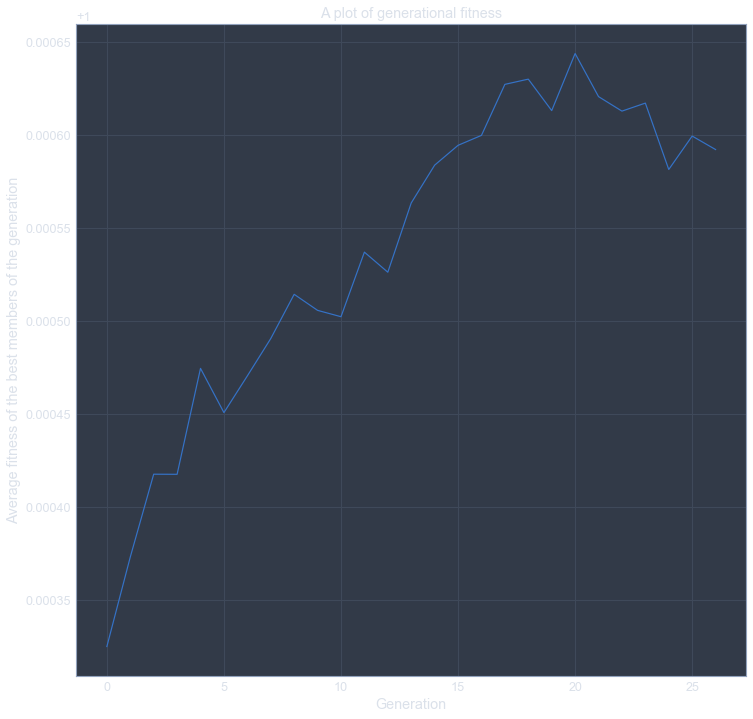

In [22]:
# We can see that the average fitness of the best members of each generation (the number used is 
# determined by the 'aristocracy' argument) generally improves until it levels off and the stop_gap
# argument terminates the algorithm at 26 generations (at least it did so for my running of the algorithm)
plt.figure(figsize=(12,12))
plt.plot(gen_fitness)
plt.xlabel('Generation')
plt.ylabel('Average fitness of the best members of the generation')
plt.title('A plot of generational fitness') ;

In [23]:
# We can look at what the best solution actually looks like. It is a tuple of two dataframes and an 
# integer. The indexes of the dataframe tell us which measures are used to form buy and sell signalls.
# The 'params' column tells us the parameter values used in the 'get_measures' function that define the
# measures used to generate the signals. The cutoffs column defines the standardised value above or below
# which the measure contributes a positive signal, and the gls column defines whether the measure must be
# above or below the cutoff to trigger the signal. A buy or sell signal is generated for a particular
# stock once all the measures produce a positive signal. The first dataframe determines buy signals and
# the second dataframe determines the sell signals. Finally, the integer in the tuple tells us the
# maximum number of stocks to hold in the portfolio.
king[0]

(                         params   cutoffs gls
 moving-average    [74, 124, 30]   1.42771   0
 bol_context_30            [127]  -1.12284   1
 price_context_70             [] -0.802396   0,
                   params   cutoffs gls
 return_context_10   [83]  0.235329   0
 price_context_15      [] -0.150955   1,
 12)

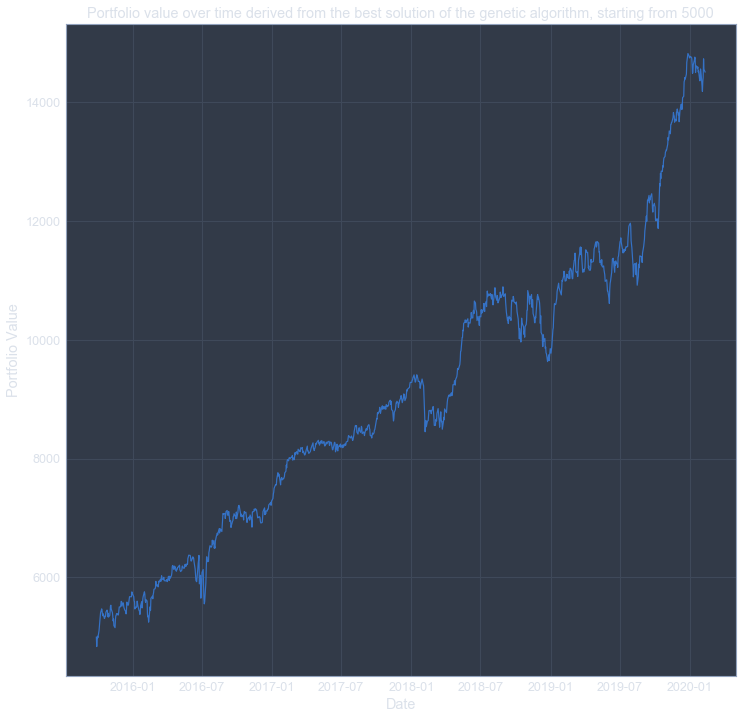

In [24]:
# The plot below gives us the in-sample performance of following the 'king' discussed above. Note that
# the plot joins together the portfolio value as evaluated only on those dates when a trade takes place
# (this helps the simulation that generates the plot to run faster).
dynamic_portfolio,dynamic_total,final_total = diagnostic_fit(king[0])
plt.figure(figsize=(12,12))
plt.plot(pd.Series(dynamic_total))
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio value over time derived from the best solution of the genetic algorithm, starting from 5000');

## Sub-part 2: Taking a look at the higher level GA

In [25]:
# I split the data into training data, on which the lower level genetic algorithm operates, and
# validation data, in which the results of the lower GA are evaluated pseudo-out-of-sample and used
# as a fitness function.
Topens,Tcloses,Tprices,Tdelta_context,Tprice_context,Tpv_context,Vopens,Vcloses,Vprices,Vdelta_context,Vprice_context,Vpv_context = borg_split(
    0.7,'b',5,0.1,opens,closes,prices,delta_context,price_context,pv_context)

In [26]:
# I load the setup information into the algorithm by fixing it into the fitness functions with 'partial.'
# The resultant functions take only potential solutions as arguments
Tfit = partial(fitness,prices=Tprices,closes=Tcloses,action_prices=Topens,ma_keys=ma_keys,bol_keys=bol_keys,
             growth_keys=growth_keys,supmax_keys=supmax_keys,supmin_keys=supmin_keys,
             return_keys=return_keys,pvma_keys=pvma_keys,delta_context=Tdelta_context,
             price_context=Tprice_context,pv_context=Tpv_context)
Tfinal_fit = partial(final_fitness,prices=Tprices,closes=Tcloses,action_prices=Topens,ma_keys=ma_keys,
                    bol_keys=bol_keys,growth_keys=growth_keys,supmax_keys=supmax_keys,
                    supmin_keys=supmin_keys,return_keys=return_keys,pvma_keys=pvma_keys,
                    delta_context=Tdelta_context,price_context=Tprice_context,pv_context=Tpv_context)
val_fit = partial(validation_fitness,prices=Vprices,closes=Vcloses,action_prices=Vopens,ma_keys=ma_keys,
                    bol_keys=bol_keys,growth_keys=growth_keys,supmax_keys=supmax_keys,
                    supmin_keys=supmin_keys,return_keys=return_keys,pvma_keys=pvma_keys,
                    delta_context=Vdelta_context,price_context=Vprice_context,pv_context=Vpv_context)

In [27]:
%%time
# I run the higher level genetic algorithm, but only for three generations and with very small sub
# populations and sub generations in the lower level genetic algorithm. This is just so you get the idea.
# Running this properly takes a day or two. You can also save your progress and use override arguments
# to continue training.
god = divinity(divi_fitness,Tfit,Tfinal_fit,val_fit,zeus,how_many_params,6,16,0.8,6,3,20,
                   orgy,20,0.8,10,10,4)

Wall time: 2h 34min 1s


In [28]:
pop, scores, gen_fitness, king, ranked_index = god

In [32]:
# The resultant population is a list of pairs of lists of ones and zeros. The ones indicate the inclusion
# of a measure from the corresponding iloc of a param_guide, such as how_many_params, within the buy or 
# sell seeds, whereas a zero indicates exclusion.
print(pop[:2])

[([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ([1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [39]:
# The population is used to generate these sorts of buy and sell seeds, which we randomly selected
# earlier to run the lower level genetic algorithm.
print([how_many_params.iloc[[i for i in range(len(how_many_params)) if pop[k][0][i] == 1]] for k in 
             range(len(pop[:2]))])
print('-------------------------------------------------------')
print([how_many_params.iloc[[i for i in range(len(how_many_params)) if pop[k][1][i] == 1]] for k in 
             range(len(pop[:2]))])

[price-volume         3
ma_context_50        2
supmax_context_15    1
dtype: int64, bol                  1
price-volume         3
ma_context_50        2
supmax_context_15    1
pv_context_5         0
dtype: int64]
-------------------------------------------------------
[price-volume         3
supmin_context_15    1
return_context_20    1
dtype: int64, supmin_context_15    1
return_context_1     1
dtype: int64]


In [72]:
# This is the very short genertional fitness from this run.
gen_fitness

[1.0004604479826278, 1.0004879300483362, 1.000528637366152]